In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120318_862.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120001_274.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_121127_408.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120240_192.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120647_346.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_121455_026.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120342_818.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120722_311.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120418_617.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_121438_997.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120745_997.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_121130_892.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_115941_714.jpg
/kaggle/input/cottondata/CottonData/Healthy/IMG_20210921_120602_

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import MaxPooling2D
from glob import glob
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# Define image constrains (width and height, dataset batch size  and channels )
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

In [5]:
# LOAD DATASET 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/cottondata/CottonData",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 258 files belonging to 2 classes.


In [6]:
len(dataset)

9

In [7]:
# Dataset folders
class_names = dataset.class_names
print(class_names)

['CurlVirus', 'Healthy']


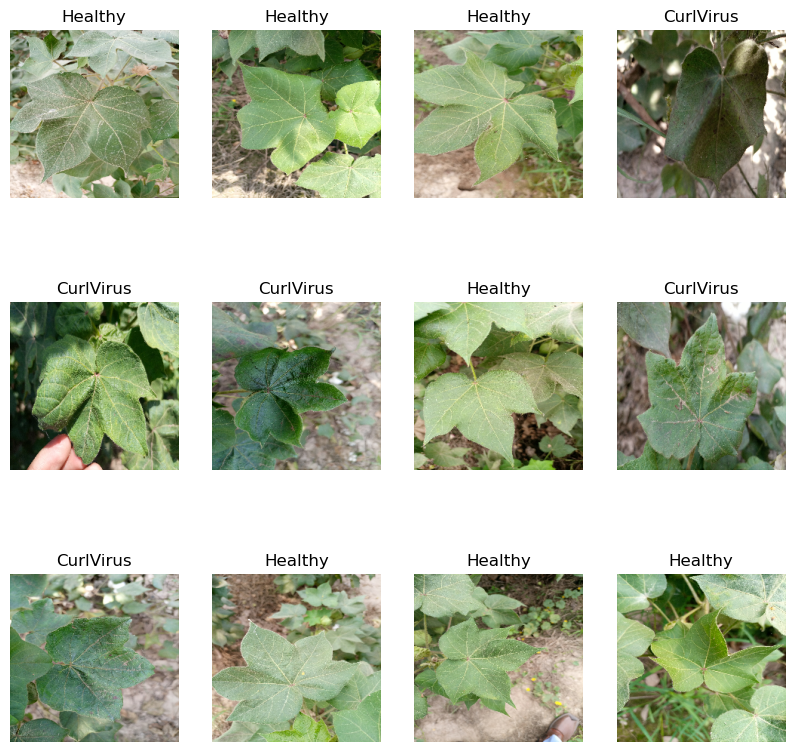

In [8]:
# PLot images from the dataset
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [20]:
def split_dataset(ds, train_sp=0.7, val_sp=0.2, test_sp=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
         
    train_size = int(train_sp * ds_size)
    val_size = int(val_sp * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [21]:
# Assing split values to respective spilts
train_ds, val_ds, test_ds = split_dataset(dataset)

In [22]:
len(train_ds)

6

In [23]:
len(val_ds)

1

In [24]:
len( test_ds)

2

**Data transformation**

In [25]:
# Define a model layer to be used by the CNN model to resize the images input into 224 * 224 and rescale them to values between 0 and 1
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Image transformations to generate more training data**


In [26]:
# Define a model layer for flipping and rotating images to create more training data and help improve the learning process
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

**CNN Model**

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [28]:
model.build(input_shape=input_shape)

In [29]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 111, 111, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 52, 52, 64)         

In [30]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [31]:
history = model.fit(train_ds,
         epochs=45,
         validation_data=val_ds,
         batch_size=BATCH_SIZE,
         verbose=1)
# steps_per_epoch=len(training_set)
# validation_steps=len(test_set)

Epoch 1/45
6/6 [==============================] - 37s 4s/step - loss: 0.7326 - accuracy: 0.5802 - val_loss: 0.7542 - val_accuracy: 0.5000
Epoch 2/45
6/6 [==============================] - 34s 4s/step - loss: 0.6749 - accuracy: 0.5988 - val_loss: 0.6902 - val_accuracy: 0.5938
Epoch 3/45
6/6 [==============================] - 34s 4s/step - loss: 0.6914 - accuracy: 0.5494 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/45
6/6 [==============================] - 34s 4s/step - loss: 0.6903 - accuracy: 0.5494 - val_loss: 0.6823 - val_accuracy: 0.6250
Epoch 5/45
6/6 [==============================] - 32s 4s/step - loss: 0.6814 - accuracy: 0.5926 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 6/45
6/6 [==============================] - 35s 4s/step - loss: 0.6870 - accuracy: 0.5365 - val_loss: 0.6744 - val_accuracy: 0.6250
Epoch 7/45
6/6 [==============================] - 32s 4s/step - loss: 0.6871 - accuracy: 0.5370 - val_loss: 0.6710 - val_accuracy: 0.6562
Epoch 8/45
6/6 [==================

In [32]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 11s 30ms/step - loss: 0.2917 - accuracy: 0.8529


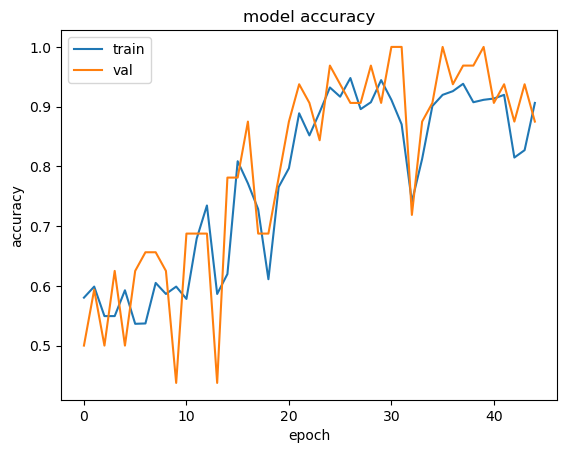

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

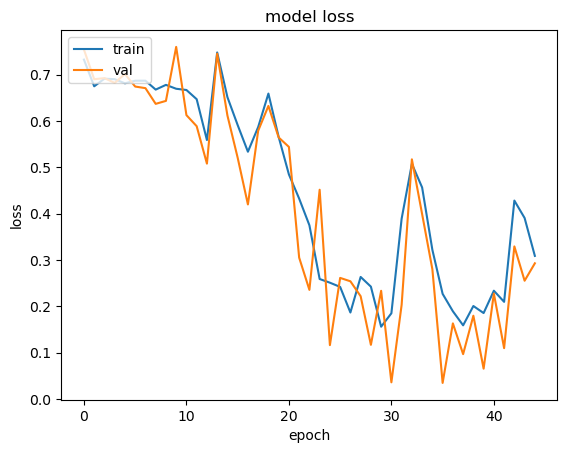

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
test_dir = '/kaggle/input/cottondata/CottonData'

In [36]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    label_mode=None,

)

Found 258 files belonging to 1 classes.


In [37]:
len(test_dataset)

9

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 42ms/step


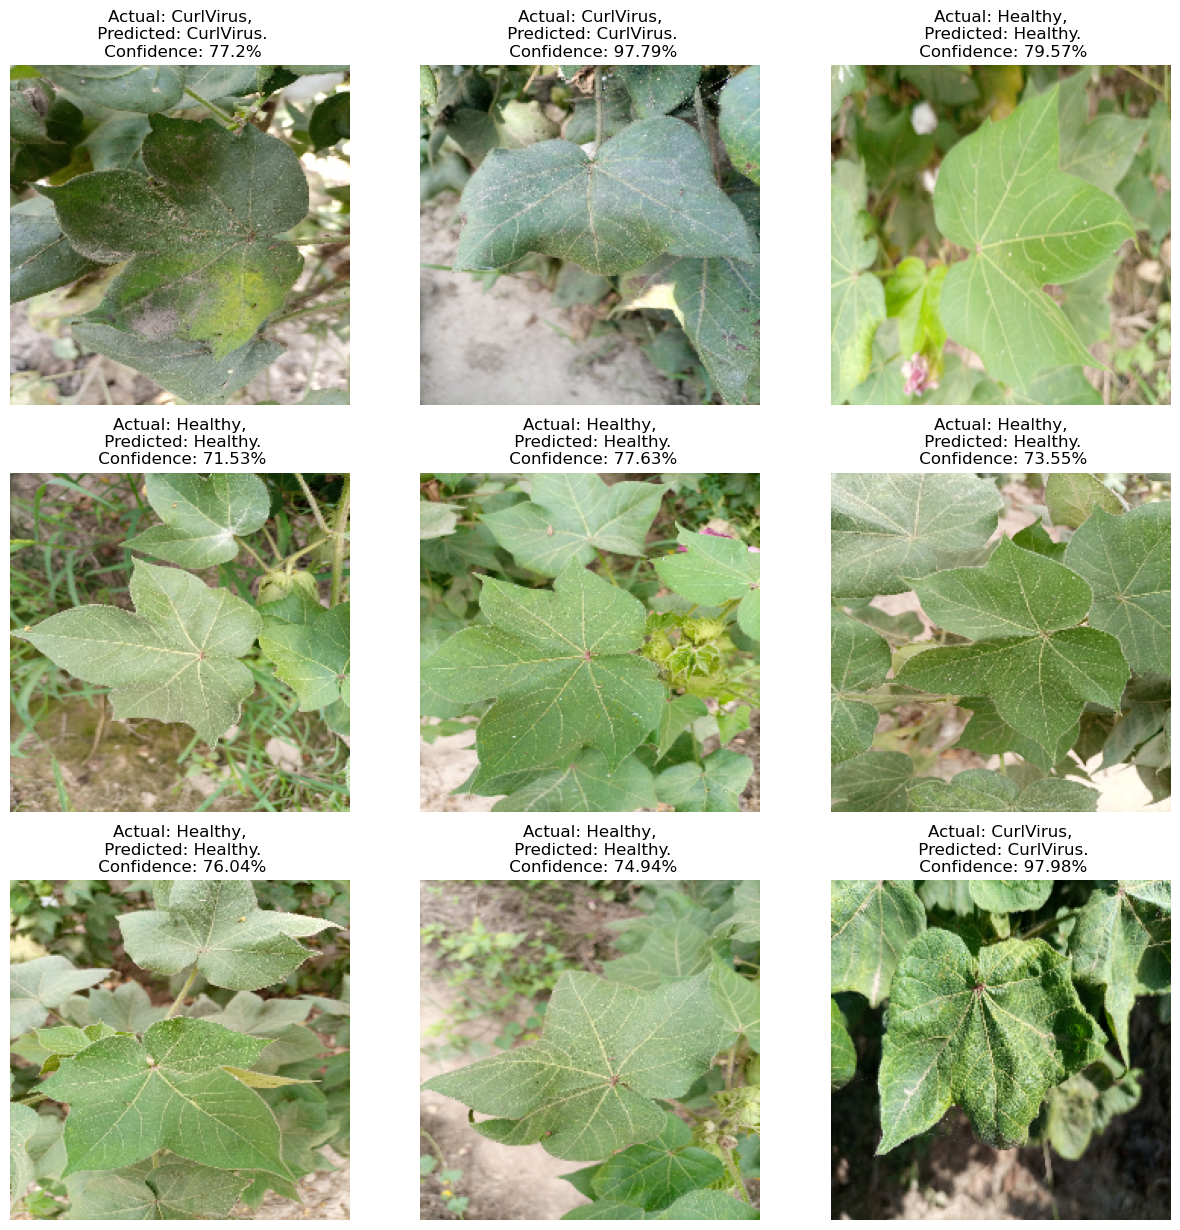

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
pred_probs = model.predict(test_ds) 

2/2 [==============================] - 12s 32ms/step


In [74]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_true = []

for batch in test_ds:
    y_true.extend(batch[1].numpy()) 

y_true = np.array(y_true)

In [70]:
y_true

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

In [71]:
y_pred = np.argmax(pred_probs, axis=1)

In [72]:
y_pred

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

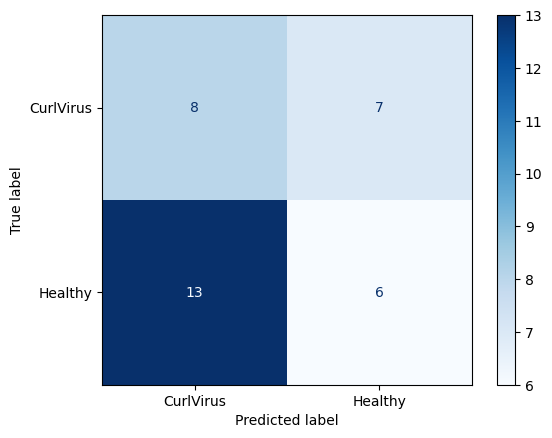

In [73]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()